<a href="https://colab.research.google.com/github/MohamedAteya/Neural-Machine-Translation-With-Attention/blob/master/Neural_Machine_Translation_With_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
import unicodedata
import io
import os
import time
import gc
from gensim.models import FastText
import random

#Download and prepare the dataset

In [70]:
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip 'fra-eng.zip'

--2020-09-27 10:36:19--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 172.67.173.198, 104.24.109.196, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6073837 (5.8M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   5.79M  15.4MB/s    in 0.4s    

2020-09-27 10:36:20 (15.4 MB/s) - ‘fra-eng.zip.1’ saved [6073837/6073837]

Archive:  fra-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: _about.txt              
replace fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fra.txt                 


##load the data

In [71]:
#load dataset
def load_data(path):
  input_file = os.path.join(path)
  with open(input_file, 'r') as f:
    data = f.read()
  
  return data.split('\n')

In [72]:
data = load_data('fra.txt')

In [73]:
data[0]

'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'

##Extract English and french sentences

In [74]:
#extract the sentences 
def get_langs(data):
  eng, fra =[], []
  for line in data:
    sentences= line.split('\t')

    #there is some empety lines (0 elemnts lists)
    if len(sentences) < 3:
      continue
    
    e_sent, f_sent, _ = sentences 

    #append the sentences
    eng.append(e_sent)
    fra.append(f_sent) 

  return  eng, fra

In [75]:
eng, fra= get_langs(data)

##Preprocessing the sentences

In [76]:
def perprocess_sentence(sent):
  sent = sent.lower()
  sent = re.sub(r"([?.!,¿])", r" \1 ", sent) #creating a space between words and punctuations
  sent = re.sub(r'[" "]+', " ",sent )  #replace any many-spaces with one space
  sent = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sent) #replace anything not in (a-zA-Z?.!,¿) with space
  sent = sent.strip()
  sent = '<start> ' + sent + ' <end>'

  return sent

In [77]:
eng = [perprocess_sentence(sent) for sent in eng]
fra = [perprocess_sentence(sent) for sent in fra]

In [78]:
eng[0]

'<start> go . <end>'

In [79]:
fra[0]

'<start> va ! <end>'

## Tokenization and paddding

In [80]:
def tokenize_and_pad(data, padding_maxlen =None, padding= 'post'):

  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',lower =True, oov_token = '<OOV>')
  tokenizer.fit_on_texts(data)

  lang_tensor = tokenizer.texts_to_sequences(data)

  lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor, maxlen = padding_maxlen,padding = padding)

  return tokenizer, lang_tensor

In [81]:
eng_tokenizer, eng_tensor = tokenize_and_pad(eng)
fra_tokenizer, fra_tensor = tokenize_and_pad(fra)

## Create train, validation, and test sets 

In [82]:
fra_train, fra_val, eng_train, eng_val = train_test_split(fra_tensor, eng_tensor,test_size = 0.2) 

## create the dataset 

In [83]:
#train dataset
BUFFER_SIZE = len(fra_train)
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices((fra_train, eng_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [84]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 67]), TensorShape([64, 53]))

In [85]:
#validation dataset
BUFFER_SIZE = len(fra_val)
dataset_val = tf.data.Dataset.from_tensor_slices((fra_val, eng_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

In [86]:
example_input_batch, example_target_batch = next(iter(dataset_val))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 67]), TensorShape([64, 53]))

#Bulding the Seq2Seq with attention model

## Load pre-trained French word embeddings

In [25]:
#download the fasttext frech word vectors

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
!gunzip 'cc.fr.300.bin.gz'

--2020-09-27 09:57:08--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496886212 (4.2G) [application/octet-stream]
Saving to: ‘cc.fr.300.bin.gz’

cc.fr.300.bin.gz    100%[===================>]   4.19G  21.4MB/s    in 3m 21s  

2020-09-27 10:00:30 (21.3 MB/s) - ‘cc.fr.300.bin.gz’ saved [4496886212/4496886212]



In [87]:
mod = FastText.load_fasttext_format('cc.fr.300.bin')

In [88]:
frech_vocab = fra_tokenizer.word_index
embedding_dim =300
fra_num_tokens = len(frech_vocab)+1
hits, misses =0, 0
french_embedding_matrix = np.zeros((fra_num_tokens, embedding_dim))
for word, i in frech_vocab.items():
    embedding_vector = mod.wv[word]
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        french_embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

In [89]:
#release some memory 
del mod  
gc.collect()

208

## Load pre-trained English word embeddings (GLOVE)

In [90]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2020-09-27 10:41:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-27 10:41:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-27 10:41:08--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [91]:

path_to_glove_file = 'glove.6B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [92]:
english_vocab = eng_tokenizer.word_index
embedding_dim =300
eng_num_tokens = len(english_vocab)+1
hits, misses =0, 0
english_embedding_matrix = np.zeros((eng_num_tokens, embedding_dim))
for word, i in english_vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        english_embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

misses

49

## Encoder Class

In [32]:
#Encoder
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_size, embedding_matrix):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.enc_units = enc_units
    self.Embedding = tf.keras.layers.Embedding(vocab_size , embedding_dim,
                                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                               trainable=False)
    self.Bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   recurrent_initializer='glorot_uniform'))
    
    self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
  def call(self, x):
    x = self.Embedding(x)
    x = self.Bi_lstm(x)
    output, memory,state= self.lstm(x)
    return  output , state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.enc_units))

## Bahdanau Attention Class (Additive)

In [33]:
# BahdanauAttention
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(BahdanauAttention, self).__init__()
    self.units = units
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, decoder_state , encoder_output):
    #decoder state shape (batch_size, units) . We need it at the shape of (batch_size, 1, units) for the score computaion 
    #encoder output sahpe (batch_size , seq_len, units) #seq_len is the time steps
    decoder_state = tf.expand_dims(decoder_state, axis = 1)
    score = self.V(tf.nn.tanh(self.W1(decoder_state)+ self.W2(encoder_output))) # score shape= (batch_size, max_length, 1)

    attention_weights = tf.nn.softmax(score, axis=1) ## attention_weights shape == (batch_size, max_length, 1)

    context_vector = tf.reduce_sum((attention_weights * encoder_output) , axis = 1) # context_vector shape = (batch_size, hidden_size)

    return context_vector , attention_weights


    

## Decoder Class

In [34]:
#Decoder 
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_size,embedding_matrix):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.dec_units = dec_units 
    self.Embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim,
                                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                               trainable=False)
    self.lstm = tf.keras.layers.LSTM(dec_units,
                                     recurrent_initializer ='glorot_uniform',
                                     dropout=0.2,
                                     return_sequences= True ,
                                     return_state= True)
    
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(dec_units)

  def call (self, x, hidden , enc_output):

    context_vector, attention_weights = self.attention(decoder_state = hidden, encoder_output = enc_output)

    x = self.Embedding(x) # x shape = (bach_size, 1 , embedding_dim)

    x = tf.concat([tf.expand_dims(context_vector, axis = 1), x], axis = -1) # x shape = (batch_size, 1, embedding + hidden units)

    output, memory,state = self.lstm(x)

    output = tf.reshape(output, (-1, output.shape[2])) # output sahpe = (batch_size , hidden units)

    x = self.fc(output)

    return x, state, attention_weights



## Optimizer and loss

In [35]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# Training

In [93]:
#encoder and decoder objects
vocab_in_size = fra_num_tokens
vocab_out_size = eng_num_tokens
units = 1024
steps_per_epoch_train = len(fra_train)//BATCH_SIZE
steps_per_epoch_val = len(fra_val) // BATCH_SIZE


encoder = Encoder(vocab_in_size, embedding_dim, units, BATCH_SIZE,french_embedding_matrix)
decoder = Decoder(vocab_out_size, embedding_dim, units, BATCH_SIZE,english_embedding_matrix)

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
#create checkpoints
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/Machine Translation'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## training step

In [30]:
@tf.function
def train_step(inp, targ):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

## train 

In [31]:
EPOCHS = 10
loss =[]
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  #train set
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch_train)):
    batch_loss = train_step(inp, targ)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch_train))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))




Epoch 1 Batch 0 Loss 1.5499
Epoch 1 Batch 100 Loss 0.7771
Epoch 1 Batch 200 Loss 0.7606
Epoch 1 Batch 300 Loss 0.6326
Epoch 1 Batch 400 Loss 0.6950
Epoch 1 Batch 500 Loss 0.6186
Epoch 1 Batch 600 Loss 0.6331
Epoch 1 Batch 700 Loss 0.6027
Epoch 1 Batch 800 Loss 0.6229
Epoch 1 Batch 900 Loss 0.5732
Epoch 1 Batch 1000 Loss 0.5842
Epoch 1 Batch 1100 Loss 0.5576
Epoch 1 Batch 1200 Loss 0.5411
Epoch 1 Batch 1300 Loss 0.5331
Epoch 1 Batch 1400 Loss 0.4985
Epoch 1 Batch 1500 Loss 0.5144
Epoch 1 Batch 1600 Loss 0.5469
Epoch 1 Batch 1700 Loss 0.4730
Epoch 1 Batch 1800 Loss 0.5006
Epoch 1 Batch 1900 Loss 0.4432
Epoch 1 Batch 2000 Loss 0.5531
Epoch 1 Batch 2100 Loss 0.5228
Epoch 1 Batch 2200 Loss 0.5116
Epoch 1 Loss 0.5881
Time taken for 1 epoch 2195.451734304428 sec

Epoch 2 Batch 0 Loss 0.4871
Epoch 2 Batch 100 Loss 0.4794
Epoch 2 Batch 200 Loss 0.4355
Epoch 2 Batch 300 Loss 0.4492
Epoch 2 Batch 400 Loss 0.4781
Epoch 2 Batch 500 Loss 0.4997
Epoch 2 Batch 600 Loss 0.4198
Epoch 2 Batch 700 Loss 0.

In [95]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [120]:
max_length_targ =  example_target_batch.shape[-1]
max_length_inp = example_input_batch.shape[-1]

def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = perprocess_sentence(sentence)

  inputs = [fra_tokenizer.word_index[i] for i in sentence.split()]
 # inputs = fra_tokenizer.texts_to_sequences(sentence)
  #inputs = tf.squeeze(inputs)
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = '<start> '

  enc_out, enc_hidden = encoder(inputs)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += eng_tokenizer.index_word[predicted_id] + ' '

    if eng_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [124]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    
    heatmap = ax.matshow(attention, cmap='rainbow')

    for y in range(attention.shape[0]):
        for x in range(attention.shape[1]):
            ax.text(x , y, '%.4f' % attention[y, x],
                     horizontalalignment='center',
                     verticalalignment='center', color='black')

    fig.colorbar(heatmap)

    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [125]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> est ce que vous travaillez ? <end>
Predicted translation: <start> do you work ? <end> 


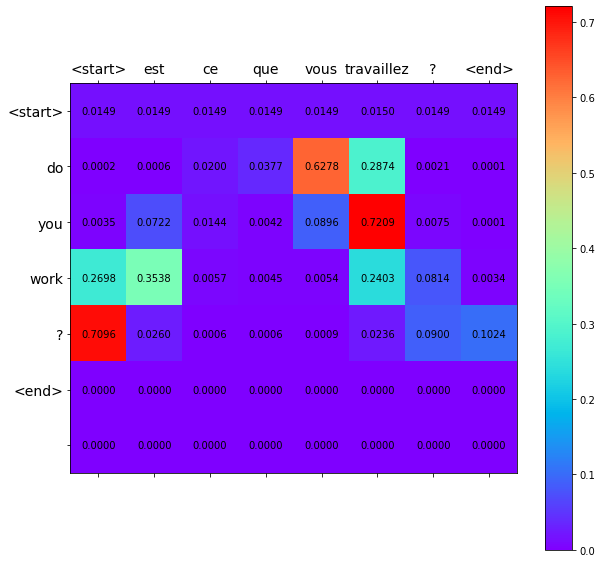

In [126]:
translate(u'Est-ce que vous travaillez?')

Input: <start> je peux vraiment traduire . <end>
Predicted translation: <start> i can really understand . <end> 


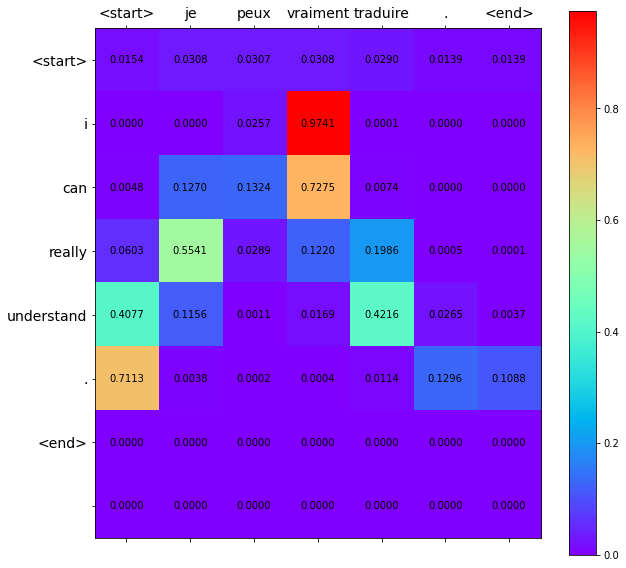

In [127]:
translate(u'Je peux vraiment traduire.')

Input: <start> comment vas tu ? <end>
Predicted translation: <start> how are you doing ? <end> 


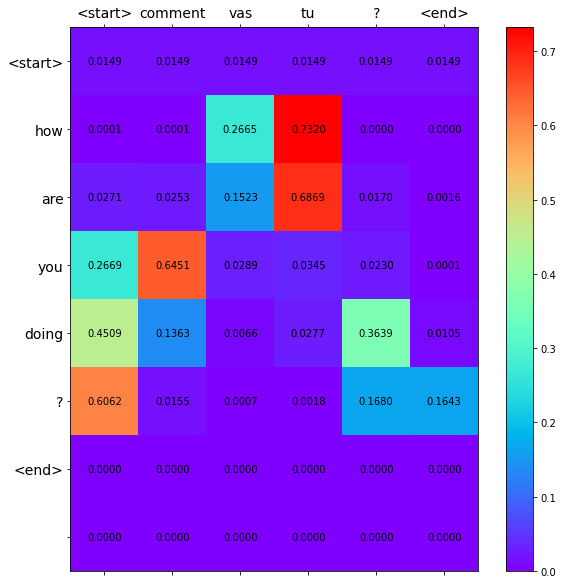

In [130]:
translate(u'Comment vas-tu?')